# Proyecto final - Portafolios

In [213]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import random
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [214]:
# leemos datos de ipc con sólo 7 acciones + MEXBOL
data = pd.read_csv('/Users/grguevara/Downloads/ipc_proy.csv',index_col=0)
data.columns = [x.replace(" MF Equity",'').replace(" INDEX",'').replace('*','') for x in data]


data.head()

,FEMSAUBD,ALSEA,WALMEX,ELEKTRA,GCARSOA1,CEMEXCPO,PINFRA,MEXBOL
DATE,,,,,,,,
1/1/16,161.63,59.85,43.49,379.04,70.98,8.72,202.73,42977.50
1/4/16,157.62,58.93,42.84,368.42,69.83,8.43,202.93,42113.70
1/5/16,157.80,59.41,42.66,357.30,70.70,8.31,203.56,42041.68
1/6/16,156.37,59.19,42.38,342.66,70.47,8.29,199.80,41691.19
1/7/16,155.14,56.93,39.99,334.15,68.15,7.64,196.75,40661.57


In [215]:
# Rendimientos
rend = (data / data.shift() - 1).dropna()
rend_MEXBOL = rend
rend = rend.drop(['MEXBOL'],axis=1)
names = rend.columns
rend.head()

,FEMSAUBD,ALSEA,WALMEX,ELEKTRA,GCARSOA1,CEMEXCPO,PINFRA
DATE,,,,,,,
1/4/16,-0.024810,-0.015372,-0.014946,-0.028018,-0.016202,-0.033257,0.000987
1/5/16,0.001142,0.008145,-0.004202,-0.030183,0.012459,-0.014235,0.003105
1/6/16,-0.009062,-0.003703,-0.006564,-0.040974,-0.003253,-0.002407,-0.018471
1/7/16,-0.007866,-0.038182,-0.056395,-0.024835,-0.032922,-0.078408,-0.015265
1/8/16,-0.016308,-0.003337,0.026007,-0.013617,-0.000587,-0.060209,-0.019416


### 1a. Modelo de rendimiento promedio constante 

In [216]:
def annual_mean(series): return series.mean() * 252
def annual_var(series): return series.var() * 252
def annual_std(series): return np.sqrt(series.var() * 252)
def res(matriz):return rend.agg(['mean',annual_mean, 'var',annual_var,'std',annual_std])   

rpc = res(rend)
rpc

,FEMSAUBD,ALSEA,WALMEX,ELEKTRA,GCARSOA1,CEMEXCPO,PINFRA
mean,0.000185,-0.000019,0.000327,0.001455,0.000224,0.000020,0.000081
annual_mean,0.046561,-0.004718,0.082426,0.366774,0.056460,0.005054,0.020384
var,0.000128,0.000235,0.000215,0.000428,0.000361,0.000411,0.000184
annual_var,0.032347,0.059311,0.054222,0.107935,0.090924,0.103473,0.046491
std,0.011330,0.015342,0.014669,0.020696,0.018995,0.020263,0.013583
annual_std,0.179851,0.243539,0.232857,0.328534,0.301537,0.321672,0.215618


### 1b. Modelo CAPM 

In [217]:
lr = 0.05
pr = 0.1 


betas = []
for x in rend.columns:
    X = rend_MEXBOL[['MEXBOL']]
    Y = rend_MEXBOL[[x]]
    lm = LinearRegression()
    lm.fit(X, Y)
    betas.append(lm.coef_[0][0])

In [218]:
tipo = ['Agresiva' if x > 1 else 'Defensiva' for x in betas]
rend_capm = [lr + pr * x for x in betas]
capm = pd.DataFrame({
    'Acción': names,
    'Beta': betas,
    'Tipo': tipo,
    'Rend esp CAPM': rend_capm
})
capm

,Acción,Beta,Tipo,Rend esp CAPM
0,FEMSAUBD,0.791768,Defensiva,0.129177
1,ALSEA,0.822097,Defensiva,0.132210
2,WALMEX,0.885452,Defensiva,0.138545
3,ELEKTRA,0.376368,Defensiva,0.087637
4,GCARSOA1,1.084677,Agresiva,0.158468
5,CEMEXCPO,1.457391,Agresiva,0.195739
6,PINFRA,0.726224,Defensiva,0.122622


### 2. Matriz de varianza-covarianza 

In [219]:
rend.cov()

,FEMSAUBD,ALSEA,WALMEX,ELEKTRA,GCARSOA1,CEMEXCPO,PINFRA
FEMSAUBD,0.000128,0.000046,0.000042,0.000009,0.000046,0.000045,0.000030
ALSEA,0.000046,0.000235,0.000057,0.000032,0.000079,0.000064,0.000049
WALMEX,0.000042,0.000057,0.000215,0.000028,0.000056,0.000048,0.000034
ELEKTRA,0.000009,0.000032,0.000028,0.000428,0.000053,0.000021,0.000026
GCARSOA1,0.000046,0.000079,0.000056,0.000053,0.000361,0.000101,0.000074
CEMEXCPO,0.000045,0.000064,0.000048,0.000021,0.000101,0.000411,0.000067
PINFRA,0.000030,0.000049,0.000034,0.000026,0.000074,0.000067,0.000184


### 3a. Frontera de carteras de mín varianza y frontera eficiente CON VENTAS EN CORTO

In [220]:
def rend_esperado(pesos): return np.dot(rend_capm,pesos)
def volat(pesos): return np.sqrt(np.dot(pesos.T,np.dot(cov,pesos)))


In [221]:
def pstats(pesos):
    rep = rend_esperado(pesos)
    vep = volat(pesos)
    return np.array([rep,vep,(rep-lr)/vep])

In [222]:
def min_sharpe(pesos):
    return -pstats(pesos)[2]

In [223]:
ventas_en_corto = True


rend = (np.log(data / data.shift())).dropna()
rend_MEXBOL = rend
rend = rend.drop(['MEXBOL'],axis=1)
rend_capm = [lr + pr * x for x in betas]
cov = rend.cov() * 252
n = len(names)
sh = -1 if ventas_en_corto else 0

reps = []
veps = []

for p in range(100_000):
    pesos = np.random.random(n)
    pesos /= np.sum(pesos)
    reps.append(rend_esperado(pesos))
    veps.append(volat(pesos))
    
reps = np.array(reps)
veps = np.array(veps)

print(reps, veps)

[0.13709543 0.12719844 0.14007961 ... 0.14472524 0.14243607 0.13549343] [0.15232867 0.159757   0.16155017 ... 0.15384656 0.14922232 0.15158112]


In [224]:
index_min_var = np.where(veps == min(veps))[0][0]
index_min_var


37573

In [225]:
frontera = np.linspace(min(rend_capm),max(rend_capm),1000)
rendsf = []
volsf = []

for p in frontera:
    cons = ({'type': 'eq', 'fun': lambda x: 1 - np.sum(x) },
           {'type': 'eq', 'fun': lambda x: np.sum(x * rend_capm) - p })
    bnds = tuple((sh,1) for x in range(n))
    opts2 = minimize(volat, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
    opt2 = pstats(opts2['x'])
    rendsv = opt2[0]
    volsv = opt2[1]
    rendsf.append(rendsv)
    volsf.append(volsv)
rendsf = np.array(rendsf)
volsf = np.array(volsf)

###  Portafolio riesgoso óptimo (max el coef de Sharpe)

In [226]:
cons = ({'type': 'eq', 'fun': lambda x: 1 -np.sum(x) })
bnds = tuple((sh,1) for x in range(n))
opts = minimize(min_sharpe, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
sharpe_opt = pstats(opts['x'])
R_esp = sharpe_opt[0]

print('\n\nCon el portafolio riesgoso óptimo')
print(f'\nEl rendimiento esperado del portafolio es: {R_esp}\nLa volatilidad: {sharpe_opt[1]}\nY el coef de Sharpe: {sharpe_opt[2]}')
print('\nY los pesos son:')

pesos = pd.DataFrame([x for x in opts['x']],index=names,columns=['Peso']).T




Con el portafolio riesgoso óptimo

El rendimiento esperado del portafolio es: 0.14494630438026046
La volatilidad: 0.1435795860543365
Y el coef de Sharpe: 0.6612799701506927

Y los pesos son:


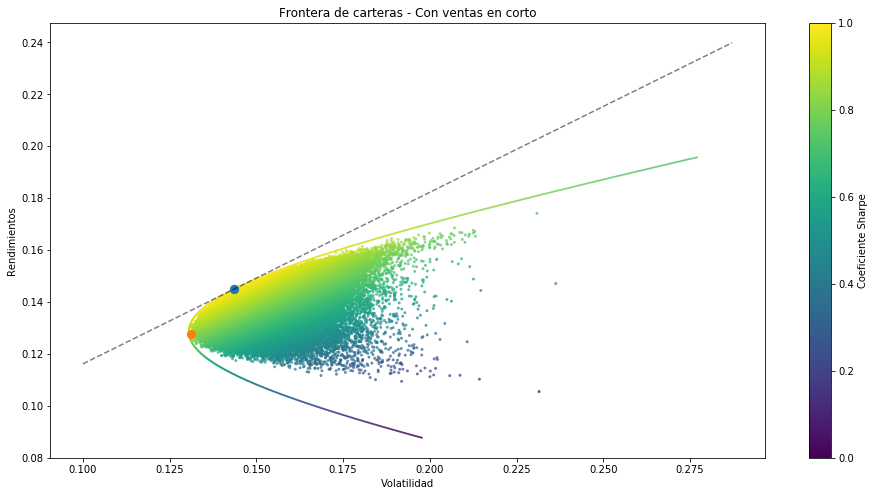

In [227]:
u = np.linspace(.1,sharpe_opt[1]*2,10)
u_ = [lr + sharpe_opt[2] * u]

plt.figure(figsize=(16,8))
plt.scatter(veps,reps,c=(reps-lr) / veps, marker = 'o',s = 4,alpha = 0.6)
plt.scatter(volsf,rendsf,c= (rendsf-lr) / volsf, marker = '.',s = 4,alpha = 0.6)
plt.scatter(sharpe_opt[1],sharpe_opt[0], marker = 'o',s = 70,alpha = 1) # max coef de Sharp
plt.scatter(veps[index_min_var],reps[index_min_var], marker = 'o',s = 70,alpha = 1) # min varianza
plt.plot(u,u_[0],c='black',alpha=.5,linestyle = '--') 
plt.xlabel('Volatilidad')
plt.ylabel('Rendimientos')
plt.colorbar(label = 'Coeficiente Sharpe')
plt.title('Frontera de carteras - Con ventas en corto')
plt.show()


### 3b. Frontera de carteras de mín varianza y frontera eficiente SIN VENTAS EN CORTO


In [228]:

ventas_en_corto = False


rend = (np.log(data / data.shift())).dropna()
rend_MEXBOL = rend
rend = rend.drop(['MEXBOL'],axis=1)
rend_capm = [lr + pr * x for x in betas]
cov = rend.cov() * 252
cov_d = rend.cov()
n = len(names)
sh = -1 if ventas_en_corto else 0

reps = []
veps = []

for p in range(100_000):
    pesos = np.random.random(n)
    pesos /= np.sum(pesos)
    reps.append(rend_esperado(pesos))
    veps.append(volat(pesos))
    
reps = np.array(reps)
veps = np.array(veps)


In [229]:
index_min_var = np.where(veps == min(veps))[0][0]

In [230]:
frontera = np.linspace(min(rend_capm),max(rend_capm),1000)
rendsf = []
volsf = []

for p in frontera:
    cons = ({'type': 'eq', 'fun': lambda x: 1 - np.sum(x) },
           {'type': 'eq', 'fun': lambda x: np.sum(x * rend_capm) - p })
    bnds = tuple((sh,1) for x in range(n))
    opts2 = minimize(volat, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
    opt2 = pstats(opts2['x'])
    rendsv = opt2[0]
    volsv = opt2[1]
    rendsf.append(rendsv)
    volsf.append(volsv)
rendsf = np.array(rendsf)
volsf = np.array(volsf)

###  Portafolio riesgoso óptimo (max el coef de Sharpe)


In [231]:
cons = ({'type': 'eq', 'fun': lambda x: 1 -np.sum(x) })
bnds = tuple((sh,1) for x in range(n))
opts = minimize(min_sharpe, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
sharpe_opt = pstats(opts['x'])
R_esp = sharpe_opt[0]

print('\n\nCon el portafolio riesgoso óptimo')
print(f'\nEl rendimiento esperado del portafolio es: {R_esp}\nLa volatilidad: {sharpe_opt[1]}\nY el coef de Sharpe: {sharpe_opt[2]}')
print('\nY los pesos son:')

pesos = pd.DataFrame([x for x in opts['x']],index=names,columns=['Peso']).T




Con el portafolio riesgoso óptimo

El rendimiento esperado del portafolio es: 0.1449363680604695
La volatilidad: 0.14356450167382118
Y el coef de Sharpe: 0.6612802395690065

Y los pesos son:


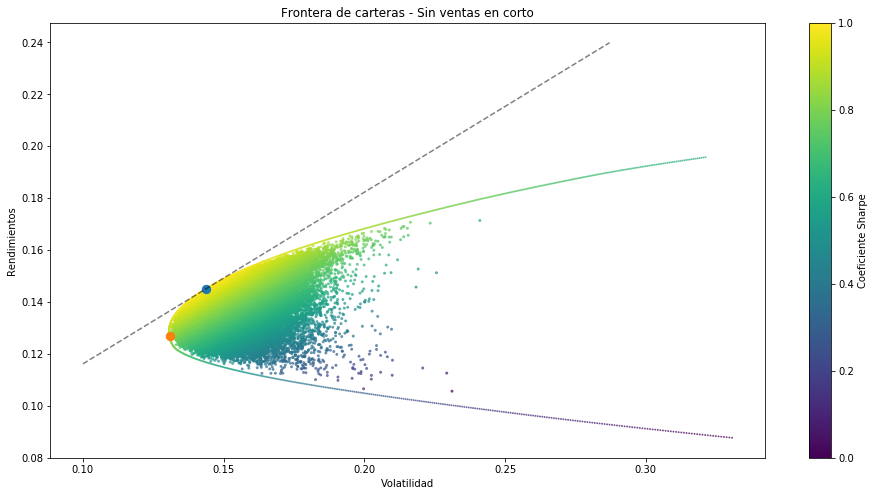

In [232]:
u = np.linspace(.1,sharpe_opt[1]*2,10)
u_ = [lr + sharpe_opt[2] * u]

plt.figure(figsize=(16,8))
plt.scatter(veps,reps,c=(reps-lr) / veps, marker = 'o',s = 4,alpha = 0.6)
plt.scatter(volsf,rendsf,c= (rendsf-lr) / volsf, marker = '.',s = 4,alpha = 0.6)
plt.scatter(sharpe_opt[1],sharpe_opt[0], marker = 'o',s = 70,alpha = 1)
plt.scatter(veps[index_min_var],reps[index_min_var], marker = 'o',s = 70,alpha = 1)
plt.plot(u,u_[0],c='black',alpha=.5,linestyle = '--') 
plt.xlabel('Volatilidad')
plt.ylabel('Rendimientos')
plt.colorbar(label = 'Coeficiente Sharpe')
plt.title('Frontera de carteras - Sin ventas en corto')
plt.show()


###  Calcula el VaR paramétrico del portafolio riesgoso óptimo (1 día, 95% de confianza)


In [261]:
M = 10_000_000

def VaR(M,confianza,freq = 'diaria'):
    a = np.sqrt(np.dot(pesos,np.dot(cov,pesos.T)))
    d = np.sqrt(np.dot(pesos,np.dot(cov_d,pesos.T)))
    veps = d if freq == 'diaria' else a
    VaR = M * norm.ppf(0.95) * veps
    return VaR,freq

var = VaR(M,0.95 ,freq = 'diaria')[0]
freq = VaR(M,0.95 ,freq = 'diaria')[1]

print(f'El VaR {freq} es: {var}')


El VaR diaria es: [[148755.85011342]]
